This notebook allows you to extract F0 until the notes and inspect along the way.

In [1]:
import importlib

import os
import sys
import json
import warnings

import numpy as np

sys.path.insert(0, '/mnt/d/projects/bassline_transcription') 

import plotting as plot
import transcription
from utilities import *
from signal_processing import *

warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

from scipy.io.wavfile import write as wav_write

# Initialization

## Directories

**TO DO: aligned_beat_positions => progression_beat_positions**

In [2]:
directories = get_directories('../directories.json')
scales, track_dicts, track_titles = read_metadata(directories)

# Listening and Waveform Inspection

Select a track to work with

In [3]:
search_idx('Amine Edge & DANCE - Get Busy', track_titles)

0


In [6]:
title = 'Axwell - Nobody Else (A-Trak Extended Remix)'

Axwell - Nobody Else (A-Trak Extended Remix)
BPM: 123.0

		Axwell - Nobody Else (A-Trak Extended Remix)

Chorus

Fs = 44100, x.shape = (344422,), x.dtype = float32


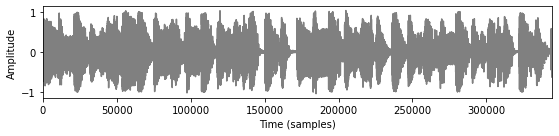

Bassline

Fs = 44100, x.shape = (345422,), x.dtype = float64


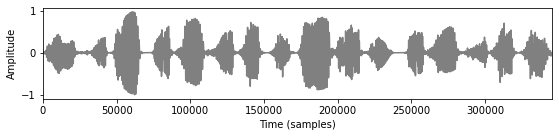

In [7]:
#title = track_titles[np.random.randint(len(track_titles))] 
print('{}'.format(title))
BPM = float(track_dicts[title]['BPM'])
print('BPM: {}\n'.format(BPM))
beat_length = 60/BPM

quarter_beat_positions = get_quarter_beat_positions(get_chorus_beat_positions(title, directories))
    
track_scale = get_track_scale(title, track_dicts, scales)

fs = 44100
chorus, bassline = load_chorus_and_bassline(title, directories) # read the chorus and the bassline
inspect_audio_outputs(title, directories)

# Spectrogram Calculation

Calculate the spectrograms of the chorus and the bassline here.

You can also apply post filtering on the spectrogram.

In [ ]:
center=True
n_fft = 4096*8

spectrogram_frame_factor = 8
win_length = int((beat_length/spectrogram_frame_factor)*fs) 
hop_length = int(win_length/4) 

bassline_spectrogram = extract_dB_spectrogram(bassline, n_fft, win_length, hop_length, center=center)

#  F0 Estimation 

## pYIN

In [ ]:
#beat_factor = 8 # for frame size quarter beat 4, 1/8th 8...
frame_factor = 8 # for frame size quarter beat 4, 1/8th 8...

#pYIN_frame_length = int((beat_length/beat_factor)*fs)
pYIN_frame_length = int((beat_length/frame_factor)*fs)



# initial estimate and the filtered version
F0_estimate, pitch_track = transcription.pYIN_F0(bassline,
                                               fs,
                                               pYIN_frame_length,
                                               threshold=0.05)

# Note Extraction

**Quantize the Pitch Track**:

in **time** to 1/4 th or 1/8 th beats or to voiced regions

in **frequency** to Notes using Scale Information and an **epsilon covering**

## Adaptive Time Quantization

importlib.reload(plot)

In [ ]:
# Quantize the pitch track
pitch_track_quantized = transcription.adaptive_voiced_region_quantization(pitch_track,
                                                            track_scale,
                                                            quarter_beat_positions, 
                                                            length_threshold=frame_factor,
                                                            epsilon=2)

# Extract the Notes for plotting
bassline_notes, unk_bassline_notes = transcription.extract_notes(pitch_track_quantized, track_scale) 

# Get Midi Representation
M = 8 # decimation rate
N_qb = frame_factor
N_bars = 4 # number of bars in the section

bassline_midi_notes = transcription.get_midi_notes(pitch_track_quantized[1],
                                                   N_qb,
                                                   M,
                                                   N_bars)

midi_path = '../data/midi_notes/new_try{}'.format(title)
np.save('{}.npy'.format(midi_path), bassline_midi_notes)

# Plots

importlib.reload(plot)

In [ ]:
plot.waveform_and_note_spectrogram(title, directories,
                                   bassline, bassline_spectrogram,
                                   fs, hop_length,
                                   bassline_notes, unk_bassline_notes,
                                   save=False)

In [ ]:
print_plot_play(chorus, fs, title)

In [ ]:
plot.note_spectrogram(title, directories,
                      bassline_spectrogram,
                      fs, hop_length,
                      bassline_notes, unk_bassline_notes)

In [ ]:
plot.spectrogram(title, directories, bassline_spectrogram, fs, hop_length, pitch_track_quantized)

In [ ]:
plot.note_comparison_spectrogram(title, directories,
                                 bassline_spectrogram,
                                 fs, hop_length,
                                 F0_estimate, bassline_notes,
                                 unk_bassline_notes,
                                 save=False, plot_title='')

## Uniform Quantization In time

Quantize each voiced region uniformly

pitch_track_quantized = uniform_voiced_region_quantization(pitch_track, scale_frequencies, epsilon=4)

bassline_notes = extract_notes(pitch_track_quantized, notes, scale_frequencies)